<a href="https://colab.research.google.com/github/neonithinar/ML_and_DL_learning_materials_and_tryouts/blob/master/BERT_classification_with_AdamW_custom_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify text (IMDb) using BERT and a custom adamW optimizer
Bidirectional Encoder Representations from transformers : is usually pretrained

In [13]:
# install dependencies
!pip install -q tensorflow-text


In [14]:
! pip install -q tf-models-official

In [15]:
import os, shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create adamw optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


In [16]:
from tensorflow import keras
import numpy as np


### Download the IMDb dataset


In [17]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = keras.utils.get_file('aclImdb_v1.tar.gz', url, untar = True,
                               cache_dir = '.', cache_subdir = '')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

#remove the unused dir to make easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb', batch_size = batch_size, validation_split = 0.2, 
    subset = 'training', seed = seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb', batch_size = batch_size, validation_split = 0.2, 
    subset = 'validation', seed = seed)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb', batch_size = batch_size, seed = seed)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)



Found 50005 files belonging to 2 classes.
Using 40004 files for training.
Found 50005 files belonging to 2 classes.
Using 10001 files for validation.
Found 50005 files belonging to 2 classes.


In [19]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f"Review: {text_batch.numpy()[i]}")
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"The film is not visually stunning in the conventional sense. It doesn't present a series of pretty pictures. Instead it is a visually interesting film. It forces the viewer to constantly process or perhaps imagine the context of the various shots. This sort of thing is easy to try but hard to succeed at. The film refuses to use the crutch of a genre to help the less than fully engaged viewer get what's going on. Instead the film touches on and moves through a number of different genres. The trick to loving the film is being able to enjoy this playfulness. I suspect 99% of North American viewers will just not get it. If you try to pin down the narrative of this film, or the philosophical message, or the symbolist structure, etc. you will waste your time. There are none of these. The film only feints towards these genres and others at times. The only unifying force in the film is Claire Denis's own sense of what fits together. There are so few feature length films that come clo

In [20]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocessing the model
Each bert model has unique preprocess models. handling them is needed to be done with keras.tfhub layer


In [21]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing the model

In [22]:
test_text = ['this an amazing movie!.']
text_preprocessed = bert_preprocess_model(test_text)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2019 6429 3185  999 1012  102    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

# Using BERT

In [23]:
# Looking at the outputs
bert_model = hub.KerasLayer(tfhub_handle_encoder)


In [24]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print('Pooled Outputs Shape: ', bert_results["pooled_output"].shape)
print('Pooled Output values: ', bert_results["pooled_output"][0, :12])
print("sequence output shape:", bert_results["sequence_output"].shape)
print(" sequence outputs values", bert_results["sequence_output"][0, :12])

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:  (1, 512)
Pooled Output values:  tf.Tensor(
[ 0.9687158   0.9960438  -0.12980714  0.2697938   0.5409835   0.78775555
  0.9611031  -0.98864305 -0.30097982 -0.99867535  0.11101914 -0.9934409 ], shape=(12,), dtype=float32)
sequence output shape: (1, 128, 512)
 sequence outputs values tf.Tensor(
[[ 0.29199913 -0.21881738  0.28494167 ... -0.6113251   0.9864454
   0.4308425 ]
 [-0.1644848  -0.29524955 -0.05785752 ...  0.45215684 -0.6695309
   0.8777451 ]
 [-0.5780081   0.07585261 -0.39754373 ...  0.13423762  0.36150524
   0.5094484 ]
 ...
 [ 0.3499833  -0.4280636  -0.05587996 ...  0.04354854  0.8366709
   0.43646896]
 [ 0.2457561  -0.11217716  0.1177868  ...  0.38979512  1.0231786
   0.28507158]
 [ 0.3914525  -0.08328421  0.18750955 ...  0.22565119  1.0466061
   0.43855244]], shape=(12, 512), dtype=float32)


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

### Define the model
simple fine fine tuned model with preprocessing model and the selected bert model. one Dense and Dropout layer

In [33]:
def build_classifier_model():
  text_input = keras.layers.Input(shape= (), dtype = tf.string, name = 'text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name = 'preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable= True, name = 'BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = keras.layers.Dropout(0.1)(net)
  net = keras.layers.Dense(1, activation = None, name = 'classifier')(net)
  return keras.Model(text_input, net)


Let's check the model runs with the output of  the proprocessing model

In [34]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_text))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7975692]], shape=(1, 1), dtype=float32)


meaningless output since the model hasn't been trained yet

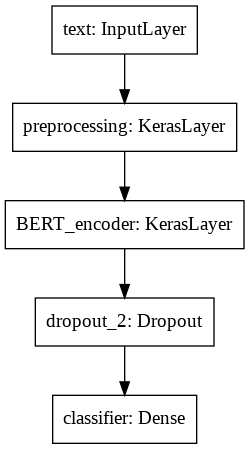

In [35]:
# plot the model

keras.utils.plot_model(classifier_model)

## Model training


### Loss function
Binary crossentropy

In [36]:
loss =keras.losses.BinaryCrossentropy(from_logits = True)
metrics = tf.metrics.BinaryAccuracy()


### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [37]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr = init_lr, 
                                          num_train_steps = num_train_steps, 
                                          num_warmup_steps= num_warmup_steps, 
                                          optimizer_type = 'adamw')

### Loading Bert model and start training

In [38]:
classifier_model.compile(optimizer = optimizer, 
                         loss = loss, 
                         metrics = metrics)

In [39]:
print('Training model with ', tfhub_handle_encoder)
history = classifier_model.fit(x = train_ds, validation_data = val_ds, epochs = epochs)

Training model with  https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1251/1251 [==============================] - 354s 279ms/step - loss: 0.7288 - binary_accuracy: 0.4975 - val_loss: 0.6987 - val_binary_accuracy: 0.5479
Epoch 2/5
1251/1251 [==============================] - 343s 274ms/step - loss: 0.6957 - binary_accuracy: 0.5185 - val_loss: 0.6145 - val_binary_accuracy: 0.6720
Epoch 3/5
1251/1251 [==============================] - 343s 274ms/step - loss: 0.6120 - binary_accuracy: 0.6350 - val_loss: 0.5146 - val_binary_accuracy: 0.7382
Epoch 4/5
1251/1251 [==============================] - 343s 274ms/step - loss: 0.4636 - binary_accuracy: 0.7598 - val_loss: 0.4307 - val_binary_accuracy: 0.7869


## Evaluate the model


In [40]:
classifier_model.evaluate(test_ds)

1563/1563 [==============================] - 146s 93ms/step - loss: 0.4307 - binary_accuracy: 0.7869


[0.4307141602039337, 0.7869012951850891]

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


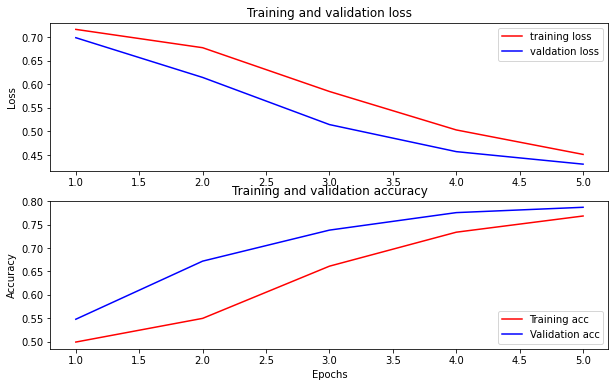

In [44]:
# Plotting accuracy over time

history_dict = history.history
print(history_dict.keys())

accu = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accu) + 1)
fig = plt.figure(figsize = (10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = "valdation loss")
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(epochs, accu, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export the model
for later use

In [45]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [46]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [47]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.594299
input: The movie was great!           : score: 0.519325
input: The movie was meh.             : score: 0.489232
input: The movie was okish.           : score: 0.086589
input: The movie was terrible...      : score: 0.570828

Results from the model in memory:
input: this is such an amazing movie! : score: 0.594299
input: The movie was great!           : score: 0.519325
input: The movie was meh.             : score: 0.489232
input: The movie was okish.           : score: 0.086589
input: The movie was terrible...      : score: 0.570828



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [48]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.594299
input: The movie was great!           : score: 0.519325
input: The movie was meh.             : score: 0.489232
input: The movie was okish.           : score: 0.086589
input: The movie was terrible...      : score: 0.570828

